# Diagnóstico de Diabetes

**Objetivo:** prever o diagnóstico de diabetes em pacientes do sexo feminino com pelo menos 21 anos de idade.

**Técnicas abordadas:** Tratamento de outliers e valores missing, Oversampling, Cross-validation

**Algoritmos de classificação utilizados:** Regressão Logística, KNN, RandomForest e XGBoost

**Método de avaliação da precisão:** accuracy_score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

/Users/brunomaciel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/diabetes_treino.csv')
df.set_index('id', inplace=True)
df.head()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
id,,,,,,,,,
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(600, 9)

In [4]:
# Funções para plotagem de gráficos personalizados
def plot_hist(dataframe):
    plt.figure(figsize=(15,9))
    i = 1
    for col in df.columns:
        plt.subplot(3, 3, i)
        plt.hist(dataframe[col], bins=20, edgecolor='black')
        plt.title(col)
        plt.grid()
        i += 1
    plt.tight_layout()
    plt.show()

# Histogramas das variáveis dividido por classe
def compare_target_hist(dataframe):
    df_targetPositive = dataframe[dataframe['classe'] == 1]
    df_targetNegative = dataframe[dataframe['classe'] == 0]

    plt.figure(figsize=(15,9))
    i = 1
    for col in df.columns:
        plt.subplot(3, 3, i)
        plt.hist(df_targetPositive[col], bins=20, edgecolor='black', label='Positivo')
        plt.hist(df_targetNegative[col], bins=20, edgecolor='orange', fill=False, hatch='/', 
                 linewidth=1.2, label='Negativo')
        plt.title(col)
        plt.grid()
        plt.legend()
        i += 1
    plt.tight_layout()
    plt.show()

# Boxplot de cada uma das variáveis
def plot_box(dataframe):
    plt.figure(figsize=(15,9))
    i = 1
    for col in dataframe.columns:
        plt.subplot(3, 3, i)
        plt.boxplot(dataframe[col])
        plt.title(col)
        i += 1
    plt.tight_layout()
    plt.show()

<br/> 
## 1. Análise Exploratória

In [5]:
# Dados duplicados? Não!
# Dados faltantes? Não!
print('Quantidade de registros duplicados:', df.shape[0] - df.drop_duplicates().shape[0])
print('Quantidade de registros null:', df.shape[0] - df.dropna().shape[0])

Quantidade de registros duplicados: 0
Quantidade de registros null: 0


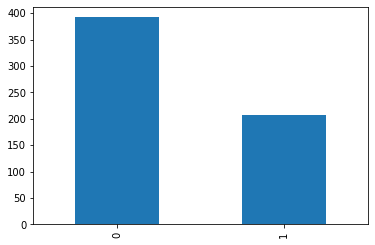

0    0.653333
1    0.346667
Name: classe, dtype: float64

In [6]:
# Divisão das classes 
df.classe.value_counts().plot(kind='bar')
plt.show()

# em (%)
df.classe.value_counts() / df.shape[0]

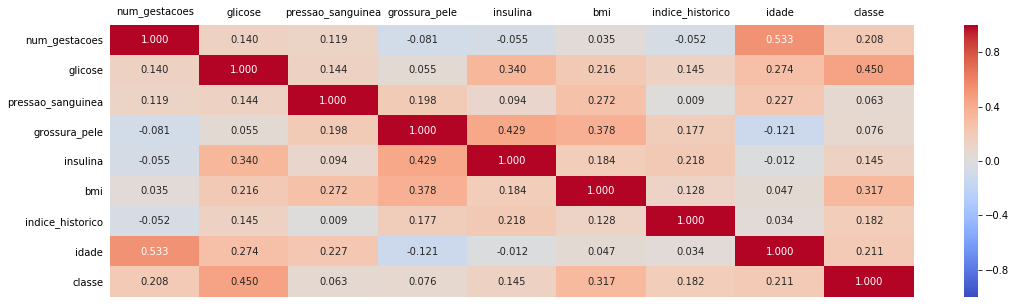

In [7]:
# Correlação entre variáveis
plt.figure(figsize=(18, 5))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.3f', vmin=-1, vmax=1)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, labeltop=True,
                bottom=False, top=False, left=False)
plt.show()

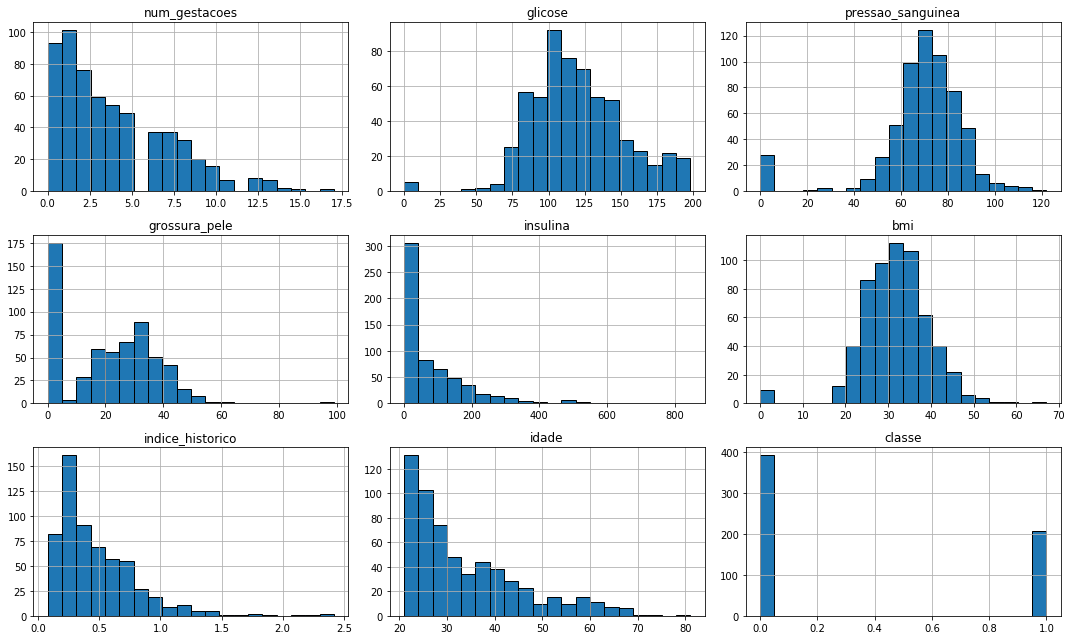

In [8]:
# Possíveis dados a serem tratados:
# 'glisose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi' == 0
# 'grossura_pele' > 80, 'insulina' > 600

plot_hist(df)

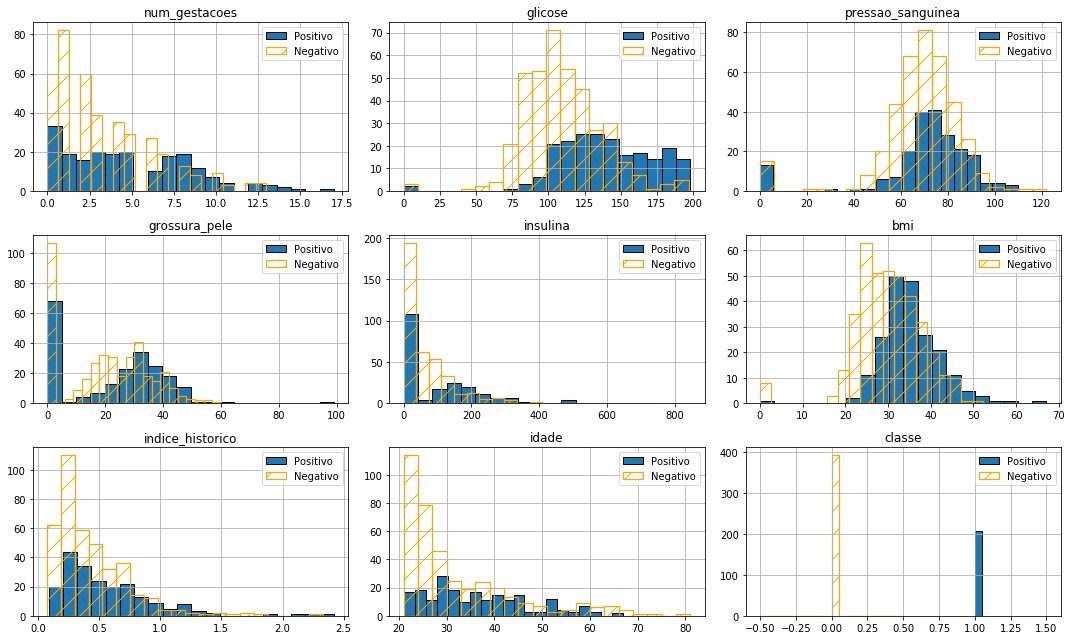

In [9]:
# Comparação Diabetes x Não Diabetes
compare_target_hist(df)

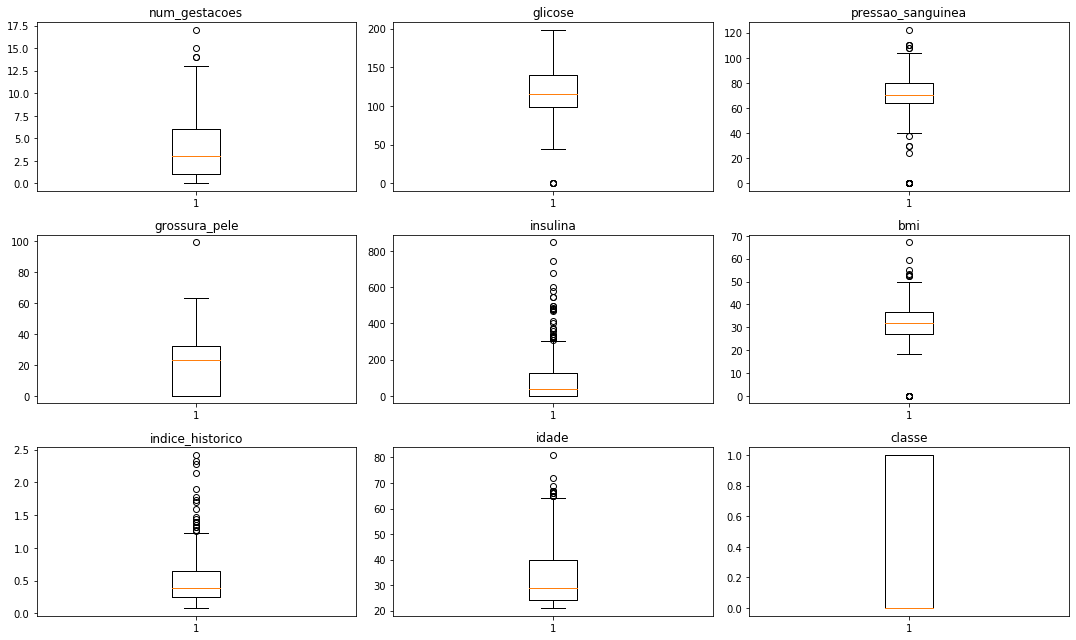

In [10]:
plot_box(df)

<br/><br/> 
### Tentativa 1
**Nenhum tratamento nos dados.**

Esssa primeira tentativa para definir um patamar de comparação, para permitir avaliar o ganho de precisão após a realização de ações de tratamento nos dados.

In [11]:
# Treino e Teste de modelo de classificação utilizando cross validation com amostras estratificadas
def train_model(modelo, features, target, name='Modelo', verbose=False):
    print(name)
    
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    results = []
    matrizes = []
    i=0
    for i_train, i_test in kfold.split(features, np.zeros(shape=(target.shape[0], 1))):
        i += 1

        model = modelo
        model.fit(features[i_train], target[i_train])
        previsoes = model.predict(features[i_test])
        score = accuracy_score(target[i_test], previsoes)
        matriz = confusion_matrix(target[i_test], previsoes)
        
        if verbose:
            print(' Fold {}: {:.4f}'.format(i, score))
        results.append(score)
        matrizes.append(matriz)

    results = np.array(results)
    matrizes = np.array(matrizes)
    print(' avg: {:.4f} +-{:.4f}'.format(results.mean(), results.std()))
    
    return results, matrizes

# Boxplot comparando os resultados para cada modelo
def compare_result_dist(dataframe, title=None, show_statistics=True, figsize=(7, 5)):
    
    plt.figure(figsize=figsize)
    sns.boxplot(data=dataframe, orient='h', showfliers=True)
    plt.title('Comparação Resultados' if title is None else title)
    plt.xlabel('score')
    plt.show()
    
    if show_statistics:
        df_stats = dataframe.describe().loc[['mean', 'min', 'max', 'std']]
        print(df_stats)

In [12]:
# Divisão atributos previsores e target
x = df.iloc[:, :-1].values
y = df.iloc[:, 8].values

# Padronização
std_scaler_x = StandardScaler()
x_scaled = std_scaler_x.fit_transform(x)

# Machine Learning
logreg_result = train_model(LogisticRegression(), features=x_scaled, target=y, name='Logistic Regression')
knn_result = train_model(KNeighborsClassifier(n_neighbors=5), features=x_scaled, target=y, name='KNN')
forest_result = train_model(RandomForestClassifier(n_estimators=90, random_state=1), features=x_scaled, target=y, 
                            name='Random Forest')
xgb_result = train_model(XGBClassifier(tree_method='hist'), features=x_scaled, target=y, name='XGBoost')

# Resultados
results_dict = {'Logistic Regression': logreg_result[0], 
              'KNN': knn_result[0], 
              'Random Forest': forest_result[0], 
              'XGBoost': xgb_result[0]}
results1_df = pd.DataFrame(results_dict)
results1_df.describe().loc[['mean', 'std']]

Logistic Regression
 avg: 0.7767 +-0.0382
KNN
 avg: 0.7333 +-0.0422
Random Forest
 avg: 0.7567 +-0.0448
XGBoost
 avg: 0.7700 +-0.0557


,Logistic Regression,KNN,Random Forest,XGBoost
mean,0.776667,0.733333,0.756667,0.770000
std,0.040215,0.044444,0.047271,0.058689


<br/> 
## 2. Limpeza dos Dados

In [13]:
df.describe()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,3.820000,120.135000,68.681667,20.558333,79.528333,31.905333,0.481063,33.278333,0.346667
std,3.362009,32.658246,19.360226,16.004588,116.490583,8.009638,0.337284,11.822315,0.476306
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.075000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.500000,32.000000,0.384000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,122.750000,36.525000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
def replace_0_by_mean_and_class(dataframe, col):
    # Coleta a média da coluna de acordo com a classe
    col_avg_positive = dataframe.query("{} > 0 & classe == 0".format(col)).mean()[col]
    col_avg_negativo = dataframe.query("{} > 0 & classe == 1".format(col)).mean()[col]
    
    # Series com valores a serem substituidos
    values_to_be_replaced = dataframe[col][dataframe[col] == 0]
    
    # Series com valores após substituição
    col_with_class0 = values_to_be_replaced[dataframe['classe'] == 0].replace(0, col_avg_negativo)
    col_with_class1 = values_to_be_replaced[dataframe['classe'] == 1].replace(0, col_avg_positive)
    replaced_values = col_with_class0.append(col_with_class1)
    
    return replaced_values

#### a) Tratamento de Outliers
Substitui por 0, pois posteriormente valores 0 serão tratados como valores missing

Aplicado as variáveis *grossura_pele*, *insulina*

In [15]:
df2 = df.copy()

# grossura_pele > 70
df2['grossura_pele'][df2['grossura_pele'] > 70] = 0

# insulina > 600
df2['insulina'][df2['insulina'] > 600] = 0

#### b) Tratamento de Valores 0 (valores missing)
Substitui pela média de acordo com a classe

Aplicado as variáveis *glicose*, *pressao_sanguinea*, *grossura_pele*, *insulina*, *bmi*

In [16]:
# Colunas 'glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi'
for col in ['glicose', 'pressao_sanguinea', 'grossura_pele', 'insulina', 'bmi']:
    print('Valores missing(0) em {}: {}'.format(col, df2[col][df2[col] == 0].count()))

Valores missing(0) em glicose: 5
Valores missing(0) em pressao_sanguinea: 28
Valores missing(0) em grossura_pele: 176
Valores missing(0) em insulina: 292
Valores missing(0) em bmi: 9


In [17]:
# Substitui valores missing pela media
df3 = df2.copy()

# glicose
glicose_replaced = replace_0_by_mean_and_class(df3, 'glicose')
df3['glicose'].replace(0, glicose_replaced, inplace=True)

# pressao_sanguinea
pressao_replaced = replace_0_by_mean_and_class(df3, 'pressao_sanguinea')
df3['pressao_sanguinea'].replace(0, pressao_replaced, inplace=True)

# grossura_pele
pele_replaced = replace_0_by_mean_and_class(df3, 'grossura_pele')
df3['grossura_pele'].replace(0, pele_replaced, inplace=True)

# insulina
insulina_replaced = replace_0_by_mean_and_class(df3, 'insulina')
df3['insulina'].replace(0, insulina_replaced, inplace=True)

# bmi
bmi_replaced = replace_0_by_mean_and_class(df3, 'bmi')
df3['bmi'].replace(0, bmi_replaced, inplace=True)

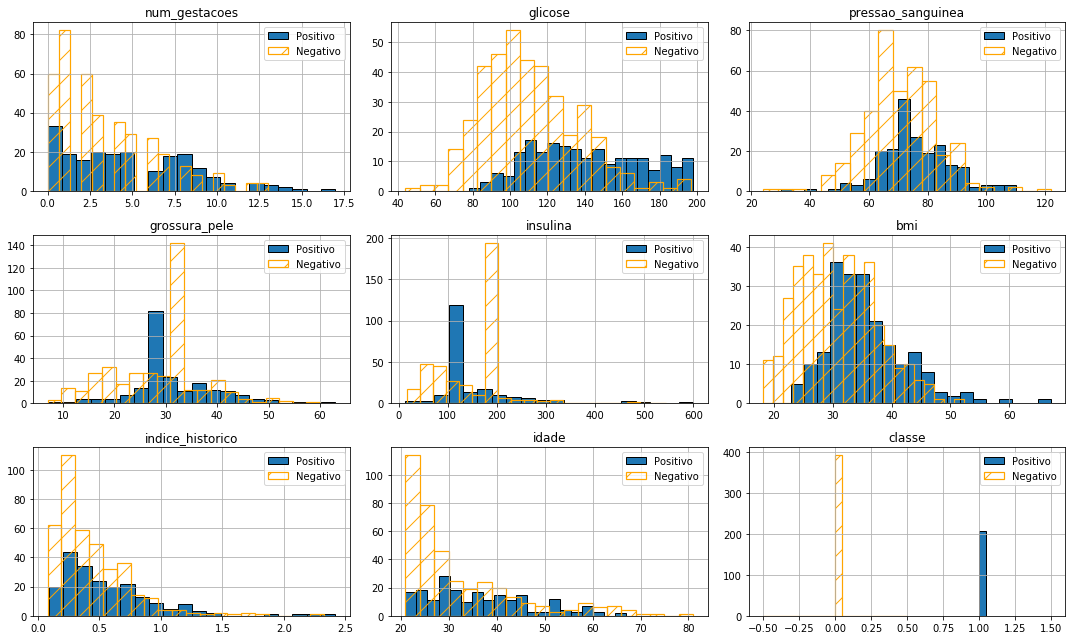

In [18]:
# Comparação Diabetes x Não Diabetes
compare_target_hist(df3)

<br/><br/> 
### Tentativa 2
**Tratamento de outliers e valores missing (0).**

Logistic Regression
 avg: 0.7717 +-0.0350
KNN
 avg: 0.8017 +-0.0241
Random Forest
 avg: 0.8667 +-0.0197
XGBoost
 avg: 0.8800 +-0.0245


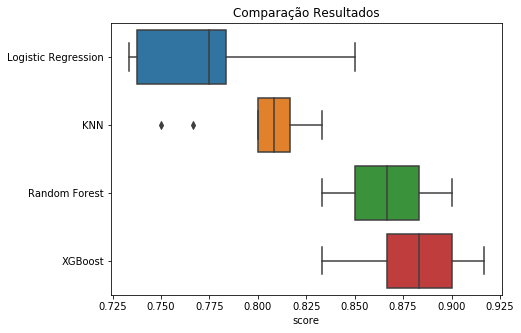

      Logistic Regression       KNN  Random Forest   XGBoost
mean             0.771667  0.801667       0.866667  0.880000
min              0.733333  0.750000       0.833333  0.833333
max              0.850000  0.833333       0.900000  0.916667
std              0.036893  0.025398       0.020787  0.025820


In [19]:
# Divisão atributos previsores e target
x = df3.iloc[:, :-1].values
y = df3.iloc[:, 8].values

# Padronização
std_scaler_x = StandardScaler()
x_scaled = std_scaler_x.fit_transform(x)

# Machine Learning
logreg_result2 = train_model(LogisticRegression(), features=x_scaled, target=y, name='Logistic Regression')
knn_result2 = train_model(KNeighborsClassifier(n_neighbors=5), features=x_scaled, target=y, name='KNN')
forest_result2 = train_model(RandomForestClassifier(n_estimators=90, random_state=1), features=x_scaled, target=y, 
                            name='Random Forest')
xgb_result2 = train_model(XGBClassifier(tree_method='hist'), features=x_scaled, target=y, name='XGBoost')

# Resultados 
results_dict = {'Logistic Regression': logreg_result2[0], 
                'KNN': knn_result2[0], 
                'Random Forest': forest_result2[0], 
                'XGBoost': xgb_result2[0]}
results2_df = pd.DataFrame(results_dict)
compare_result_dist(results2_df)

<br/> 
## 3. Oversampling

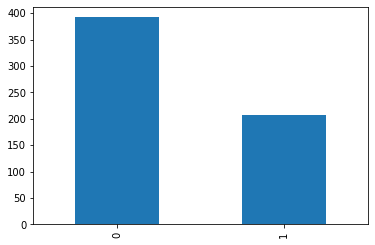

In [20]:
df3['classe'].value_counts().plot(kind='bar')
plt.show()

#### a) SMOTE

In [21]:
# SMOTE
features = df3.drop(columns=['classe']).values
target = df3['classe'].values

smote = SMOTE(sampling_strategy='minority')
x_over, y_over = smote.fit_sample(features, target)

df4 = pd.DataFrame(x_over, columns=df3.columns[:-1])
df4['classe'] = y_over

df4.classe.value_counts()

1    392
0    392
Name: classe, dtype: int64

<br/><br/> 
### Tentativa 3
**Oversampling com SMOTE**
<br/>
Além do tratamento de outliers e valores missing

Logistic Regression
 avg: 0.7512 +-0.0558
KNN
 avg: 0.8138 +-0.0335
Random Forest
 avg: 0.8930 +-0.0299
XGBoost
 avg: 0.9031 +-0.0222


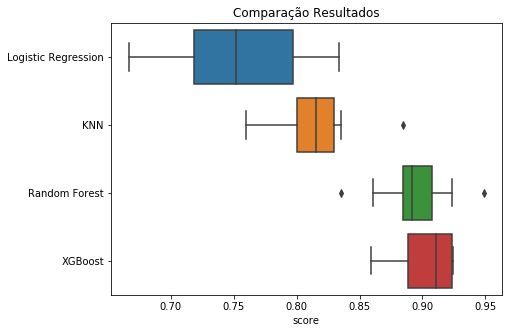

      Logistic Regression       KNN  Random Forest   XGBoost
mean             0.751201  0.813843       0.892957  0.903067
min              0.666667  0.759494       0.835443  0.858974
max              0.833333  0.884615       0.948718  0.924051
std              0.058840  0.035289       0.031495  0.023440


In [22]:
# Divisão atributos previsores e target
x = df4.iloc[:, :-1].values
y = df4.iloc[:, 8].values

# Padronização
std_scaler_x = StandardScaler()
x_scaled = std_scaler_x.fit_transform(x)

# Machine Learning
logreg_result3 = train_model(LogisticRegression(), features=x_scaled, target=y, name='Logistic Regression')
knn_result3 = train_model(KNeighborsClassifier(n_neighbors=5), features=x_scaled, target=y, name='KNN')
forest_result3 = train_model(RandomForestClassifier(n_estimators=90, random_state=1), features=x_scaled, target=y, 
                            name='Random Forest')
xgb_result3 = train_model(XGBClassifier(tree_method='hist'), features=x_scaled, target=y, name='XGBoost')

# Resultados
results_dict = {'Logistic Regression': logreg_result3[0], 
                'KNN': knn_result3[0], 
                'Random Forest': forest_result3[0], 
                'XGBoost': xgb_result3[0]}
results3_df = pd.DataFrame(results_dict)
compare_result_dist(results3_df)

#### b) SMOTE + Tomek links

In [23]:
# SMOTE + Tomek links (Oversampling + Undersampling)
features = df3.drop(columns=['classe']).values
target = df3['classe'].values

smote_tomek = SMOTETomek(sampling_strategy='auto')
x_over, y_over = smote_tomek.fit_sample(features, target)

df5 = pd.DataFrame(x_over, columns=df3.columns[:-1])
df5['classe'] = y_over

df5.classe.value_counts()

1    386
0    386
Name: classe, dtype: int64

<br/><br/> 
### Tentativa 4
**Oversampling & Undersampling com SMOTE + Tomek**
<br/>
Além do tratamento de outliers e valores missing

Logistic Regression
 avg: 0.7552 +-0.0497
KNN
 avg: 0.8329 +-0.0258
Random Forest
 avg: 0.9106 +-0.0325
XGBoost
 avg: 0.9171 +-0.0253


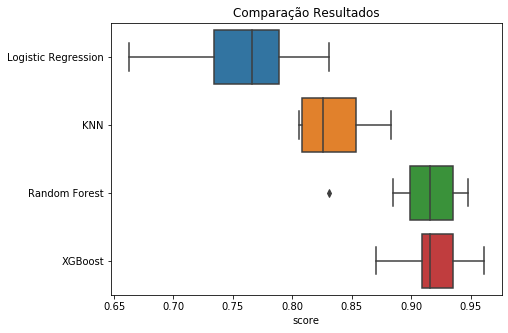

      Logistic Regression       KNN  Random Forest   XGBoost
mean             0.755228  0.832867       0.910623  0.917133
min              0.662338  0.805195       0.831169  0.870130
max              0.831169  0.883117       0.948052  0.961039
std              0.052361  0.027187       0.034271  0.026643


In [24]:
# Divisão atributos previsores e target
x = df5.iloc[:, :-1].values
y = df5.iloc[:, 8].values

# Padronização
std_scaler_x = StandardScaler()
x_scaled = std_scaler_x.fit_transform(x)

# Machine Learning
logreg_result4 = train_model(LogisticRegression(), features=x_scaled, target=y, name='Logistic Regression')
knn_result4 = train_model(KNeighborsClassifier(n_neighbors=5), features=x_scaled, target=y, name='KNN')
forest_result4 = train_model(RandomForestClassifier(n_estimators=90, random_state=1), features=x_scaled, target=y, 
                            name='Random Forest')
xgb_result4 = train_model(XGBClassifier(tree_method='hist'), features=x_scaled, target=y, name='XGBoost')

# Resultados
results_dict = {'Logistic Regression': logreg_result4[0], 
            'KNN': knn_result4[0], 
            'Random Forest': forest_result4[0], 
            'XGBoost': xgb_result4[0]}
results4_df = pd.DataFrame(results_dict)
compare_result_dist(results4_df)

<br/><br/> 
### Comparação dos Resultados

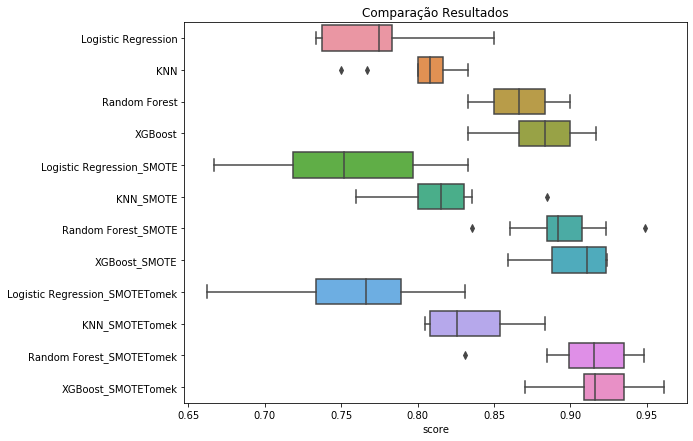

In [25]:
result_compare_df = results2_df.join(results3_df, how='inner', rsuffix='_SMOTE')
result_compare_df = result_compare_df.join(results4_df, how='inner', rsuffix='_SMOTETomek')

compare_result_dist(result_compare_df, show_statistics=False, figsize=(9, 7))

In [27]:
print(' ======= SMOTE =======')
print(results3_df[['Random Forest', 'XGBoost']].describe().loc[['mean', 'std']])

print('\n ====== SMOTE + Tomek ======')
print(results4_df[['Random Forest', 'XGBoost']].describe().loc[['mean', 'std']])

 ======= SMOTE =======
      Random Forest   XGBoost
mean       0.892957  0.903067
std        0.031495  0.023440

 ====== SMOTE + Tomek ======
      Random Forest   XGBoost
mean       0.910623  0.917133
std        0.034271  0.026643


<br/> 
## 4. Tunning de Parâmetros

In [91]:
# Divisão atributos previsores e target
x = df5.iloc[:, :-1].values
y = df5.iloc[:, 8].values

# Padronização
std_scaler_x = StandardScaler()
x_scaled = std_scaler_x.fit_transform(x)


# Cria o GridSearch para XGBoost
xgb_params = {'n_estimators' : [120, 140, 160, 180, 200, 220],
              'max_depth' : [3, 4, 5],
              'learning_rate' : [0.1, 0.05, 0.04, 0.03, 0.02],
              'gamma' : [0, 1],
              'min_child_weight': [1, 2, 3]}
xgb_grid_search = GridSearchCV(estimator=XGBClassifier(tree_method='hist'), param_grid=xgb_params, 
                           scoring='accuracy', cv=10, verbose=True)


# Cria o GridSearch para RandomForest
forest_params = {'n_estimators' : [120, 150, 180, 200, 220],
                 'max_depth' : [4, 5, 6],
                 'random_state' : [0, 1],
                 'min_samples_leaf': [1, 2, 3],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_split': [2, 3, 4]}
forest_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=forest_params, 
                                  scoring='accuracy', cv=10, verbose=True)

In [47]:
# Realiza a busca por melhores parâmetros
xgb_grid_search.fit(x_scaled, y)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5400 out of 5400 | elapsed: 20.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_p...ght=1, seed=None, silent=None,
                                     subsample=1, tree_method='hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [0, 1],
                         'learning_rate': [0.1, 0.05, 0.04, 0.03, 0.02],
       

In [89]:
xgb_grid_search.best_params_, xgb_grid_search.best_score_

({'gamma': 0,
  'learning_rate': 0.05,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 200},
 0.9221052631578945)

<br/><br/> 
## 5. Modelo Final

In [28]:
# Divisão atributos previsores e target
x = df5.iloc[:, :-1].values
y = df5.iloc[:, 8].values

x, _, y, _ = train_test_split(x, y, train_size=0.97, random_state=16)

# Padronização
scaler_x_final = StandardScaler()
x_scaled = scaler_x_final.fit_transform(x)

# Machine Learning
xgb_model_final = XGBClassifier(n_estimators=200, learning_rate=0.05, tree_method='hist', max_depth=5, gamma=0,
                                min_child_weight=1)
xgb_model_final.fit(x_scaled, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='hist', verbosity=1)

<br/><br/><br/> 
## 6. Previsão de Novos Dados

In [29]:
new_raw_data = pd.read_csv('data/diabetes_teste.csv')
new_raw_data.set_index('id', inplace=True)
new_raw_data.head()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
id,,,,,,,,
1,1,108,88,19,0,27.1,0.400,24
2,6,96,0,0,0,23.7,0.190,28
3,1,124,74,36,0,27.8,0.100,30
4,7,150,78,29,126,35.2,0.692,54
5,4,183,0,0,0,28.4,0.212,36


#### 6.1 Análise dos Novos Dados

In [30]:
new_raw_data.describe()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,3.964286,124.148810,70.619048,20.827381,104.565476,32.304167,0.438583,33.125000
std,3.441370,30.106525,19.321673,15.577120,353.528165,7.433299,0.308102,11.565584
min,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.100000,21.000000
25%,1.000000,102.000000,62.000000,0.000000,0.000000,27.675000,0.222750,23.750000
50%,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.341500,28.000000
75%,6.000000,142.500000,80.500000,32.250000,136.250000,36.650000,0.588000,42.000000
max,13.000000,212.000000,114.000000,49.000000,4444.000000,57.300000,1.698000,70.000000


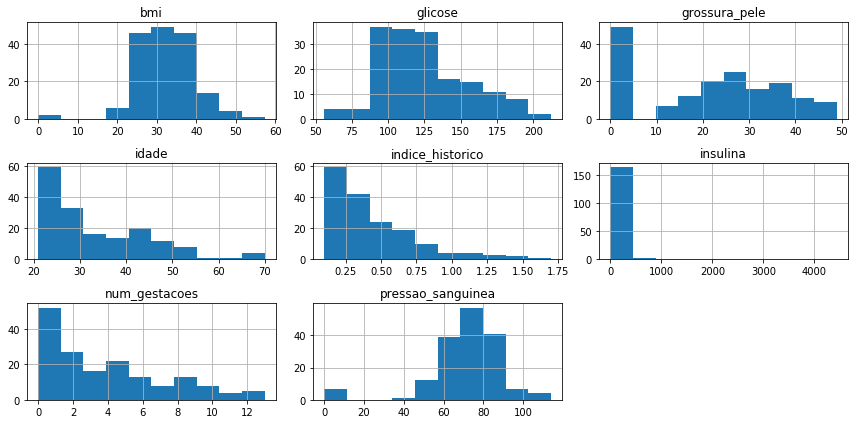

In [31]:
new_raw_data.hist(figsize=(12, 6))
plt.tight_layout()
plt.show()

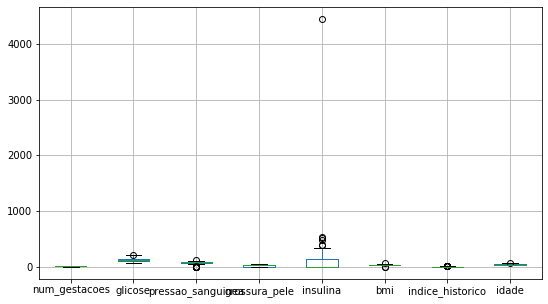

In [32]:
new_raw_data.boxplot(figsize=(9,5))
plt.show()

#### 6.2 Limpeza dos Novos Dados

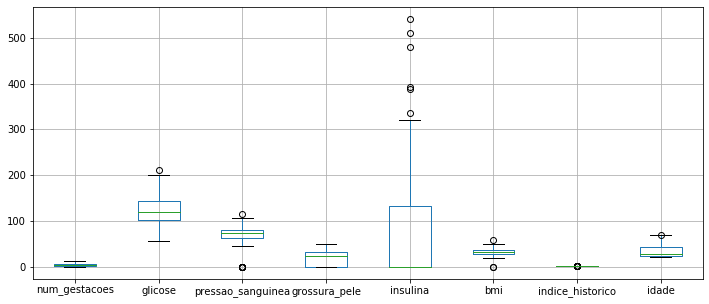

In [33]:
# Tratamento de Outlier
# Substitui por 0, pois posteriormente os valores 0 serão tratados pela média
new_data = new_raw_data.copy()

outlier = new_data['insulina'][new_data['insulina'] > 1000].values[0]
new_data['insulina'].replace(outlier, 0, inplace=True)


new_data.boxplot(figsize=(12,5))
plt.show()

In [34]:
# Tratamento de valores missing (0) pela média
new_data2 = new_data.copy()

for col in ['bmi', 'grossura_pele', 'insulina', 'indice_historico', 'pressao_sanguinea']:
    col_avg = new_data2[col][new_data2[col] > 0].mean()
    new_data2[col][new_data2[col] == 0] = col_avg

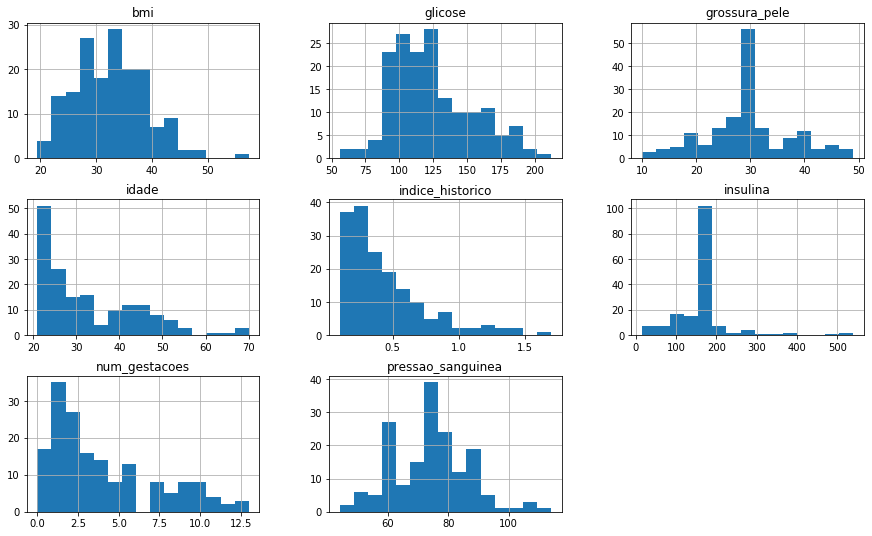

In [35]:
new_data2.hist(figsize=(15, 9), bins=15)
plt.show()

### 6.3 Previsões

In [39]:
# Normaliza os novos registros
new_data_scaled = scaler_x_final.transform(new_data2.values)

# Realiza a previsão
previsoes = xgb_model_final.predict(new_data_scaled)

# Coloca as previsoes em um DataFrame junto as variaveis previsoras
df_previsoes = new_data2.copy()
df_previsoes['previsoes'] = previsoes
df_previsoes.head()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,previsoes
id,,,,,,,,,
1,1,108,88.000000,19.000000,160.036585,27.1,0.400,24,0
2,6,96,73.689441,29.403361,160.036585,23.7,0.190,28,0
3,1,124,74.000000,36.000000,160.036585,27.8,0.100,30,0
4,7,150,78.000000,29.000000,126.000000,35.2,0.692,54,1
5,4,183,73.689441,29.403361,160.036585,28.4,0.212,36,1
